In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [21]:
%load_ext autoreload
%autoreload 2
import importlib
import math, random, copy, numpy as np
import cProfile
import yaml
from utils import class_from_package, HELMConverter
from node import MolSentenceNode
from generator import MCTS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
config_path = "config/mcts_helm.yaml"
with open(repo_root + config_path) as f:
    conf = yaml.safe_load(f)
    
model_class_name, model_dir, lang_class_name, lang_path = (conf.get(k) for k in ("model_class_name", "model_dir", "lang_class_name", "lang_path"))
lang_class = class_from_package("language", lang_class_name)
lang = lang_class.load(repo_root + lang_path)
model_class = class_from_package("transition", model_class_name)
model = model_class(lang=lang, model_dir=repo_root + model_dir)

reward_class_name, reward_conf = (conf.get(k) for k in ("reward_class_name", "reward_conf"))
reward_class = class_from_package("reward", reward_class_name)
reward = reward_class(**reward_conf)

policy_class_path, policy_conf = (conf.get(k) for k in ("policy_class_name", "policy_conf"))
policy_class = class_from_package("policy", policy_class_path)
policy = policy_class(**policy_conf)

filter_settings = conf.get("filters", [])
filters = []
for s in filter_settings:
    filter_class = class_from_package("filter", s.pop("filter_class_name"))
    filters.append(filter_class(**s))

Search is started.
0- time: 0.00, count_rollouts: 1, reward: -0.9352473568888645, node: PEPTIDE1{T.N.I.K.T.E.E.I.S.E.V.N.A.I.A.E.F.I.S.D}$$$$
1- time: 0.07, count_rollouts: 2, reward: -0.9301013973873944, node: PEPTIDE1{[ac].F.Q.S.K.G.N.V.F.V.D.G.Y.F.E.R.L.R.A.K.L.[am]}$$$$
2- time: 0.12, count_rollouts: 3, reward: -0.9510224233087499, node: PEPTIDE1{[ac].W.E.E.W.D.K.K.I.E.E.Y.T.K.K.I.E.E.L.I.K.K.S.E.E.Q.Q.K.K.N.E.E.E.L.K.K.[am]}$$$$
3- time: 0.25, count_rollouts: 4, reward: -0.8569783174631027, node: PEPTIDE1{R.L.W.K.K.I.R.W.R}$$$$
4- time: 0.28, count_rollouts: 5, reward: -0.9502959497678416, node: PEPTIDE1{Y.A.D.A.I.F.T.N.S.Y.R.K.V.L.G.Q.L.S.A.R.K.L.L.Q.D.I.M.S.R.[am]}$$$$
5- time: 0.41, count_rollouts: 6, reward: -0.8904575115700496, node: PEPTIDE1{G.R.R.K.K.F.R.W.R}$$$$
6- time: 0.44, count_rollouts: 7, reward: -0.7450868267882867, node: PEPTIDE1{F.H.L.L.L.L.A.K}$$$$
7- time: 0.46, count_rollouts: 8, reward: -0.8848802215887375, node: PEPTIDE1{A.P.C.A.N.D.H.Q.G.E.T.V}$$$$
8- time:

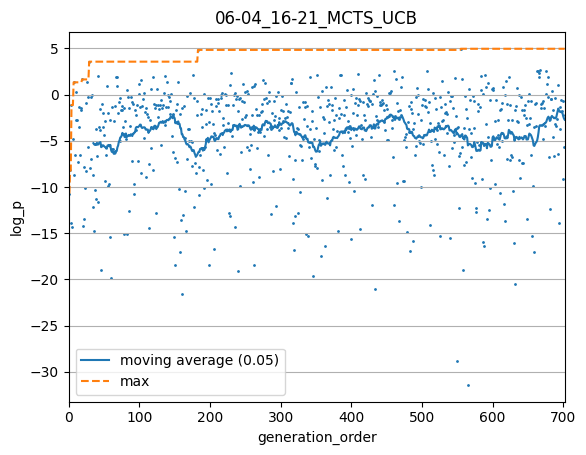

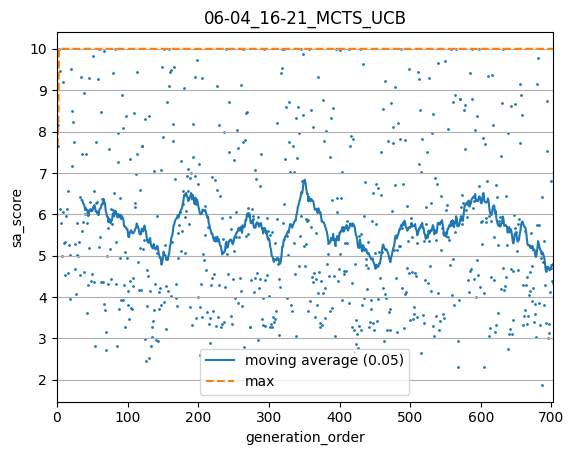

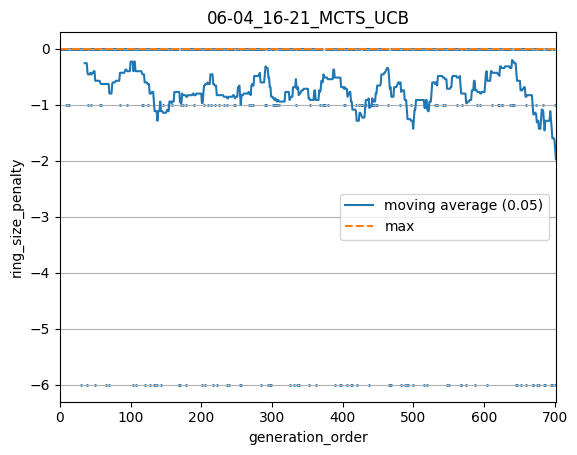

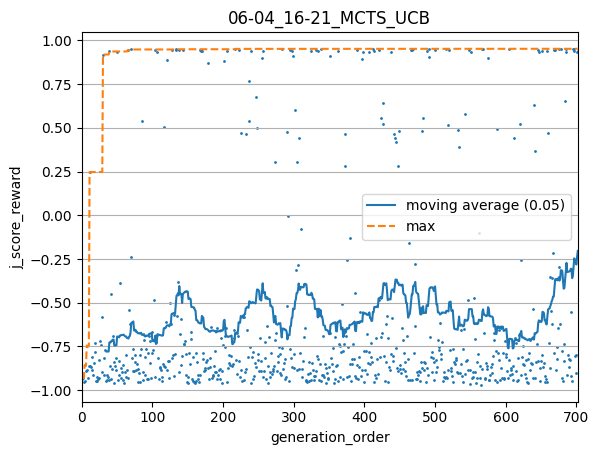

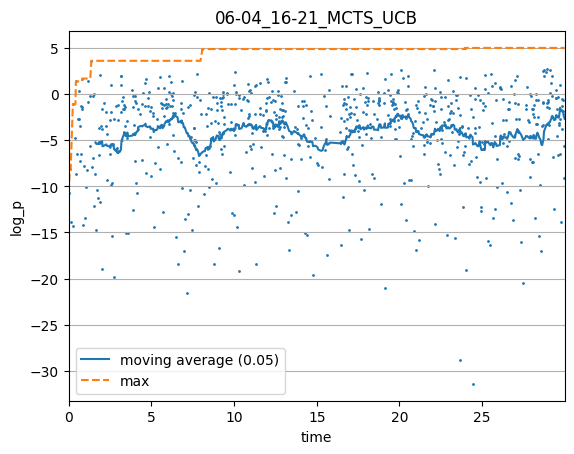

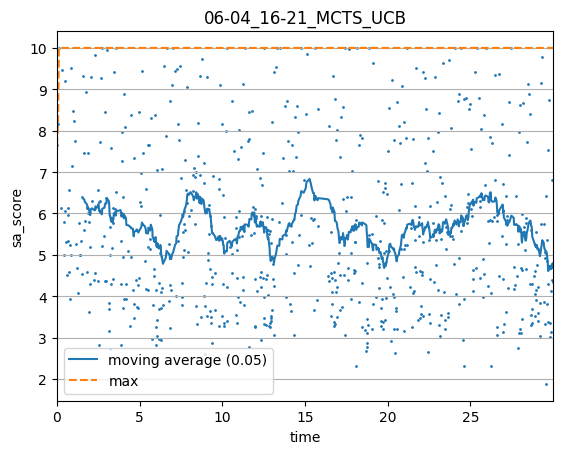

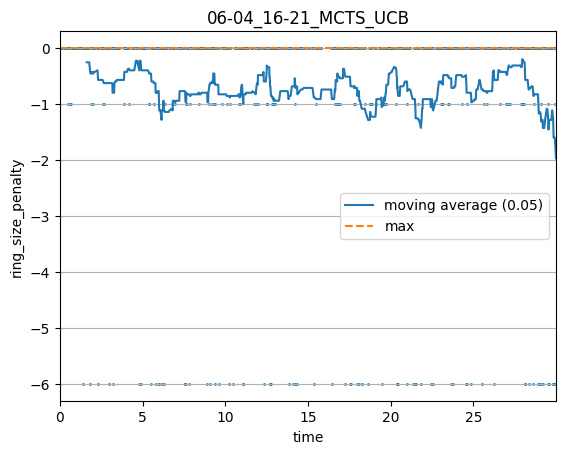

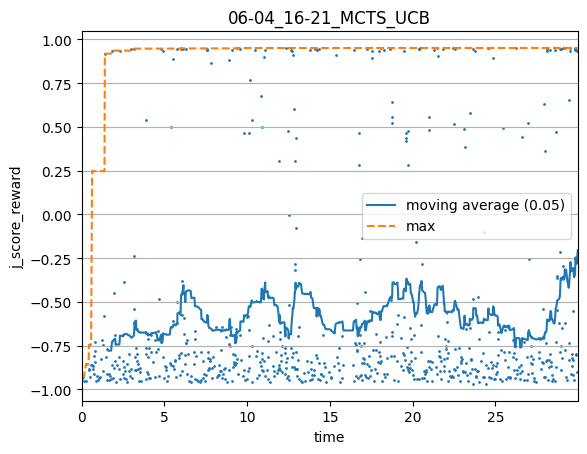

In [28]:
from rdkit import RDLogger
import shutil

RDLogger.DisableLog('rdApp.*') #invalid mols are already logged

root = MolSentenceNode.bos_node(lang) #TODO: change after root node generalization

output_dir, generation_conf = (conf.get(k) for k in ("output_dir", "generation_conf"))
generator = MCTS(transition=model, reward=reward, policy=policy, filters=filters, output_dir=output_dir)
src = repo_root + config_path
dst = generator.output_dir() + "setting.yaml"
shutil.copy(src, dst)

generator.generate(root=root, **generation_conf)
#cProfile.run("generator.generate(root=root, **generation_conf)"")

generator.plot_objective_values_and_reward(x_axis = "generation_order")
generator.plot_objective_values_and_reward(x_axis = "time")

In [7]:
#save mcts
save_path = generator.output_dir() + "test.mcts"
generator.save(save_path)

In [ ]:
#load mcts
generator = MCTS.load(save_path, model)